# Import Library yang Diperlukan
Mengimpor library seperti TensorFlow, NumPy, Pandas, Matplotlib, dan lainnya yang diperlukan untuk pelatihan model.

In [1]:
# Import Library yang Diperlukan

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
from tqdm.keras import TqdmCallback
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
)

# Setup TPU untuk Mempercepat Pelatihan
Mengonfigurasi TPU untuk mempercepat proses pelatihan menggunakan TensorFlow TPUStrategy.
TPU (Tensor Processing Unit) adalah jenis akselerator perangkat keras yang dirancang khusus oleh Google untuk mempercepat proses pembelajaran mesin.
TPU dirancang untuk menangani beban kerja komputasi intensif yang sering ditemukan dalam pelatihan model pembelajaran mendalam.
Mengonfigurasi TPU untuk mempercepat proses pelatihan menggunakan TensorFlow TPUStrategy.

In [2]:
# Fungsi untuk mengkonfigurasi TPU
def setup_tpu():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Perangkat:', tpu.master())
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    except:
        strategy = tf.distribute.get_strategy()
    print('Jumlah replikasi:', strategy.num_replicas_in_sync)
    return strategy

# Mengkonfigurasi TPU dan mencetak versi TensorFlow
strategy = setup_tpu()
print(tf.__version__)

Jumlah replikasi: 1
2.18.0


# Mendefinisikan Konstanta dan Variabel Global
Menetapkan konstanta seperti ukuran batch, ukuran gambar, dan variabel global lainnya.

In [3]:
# Menetapkan konstanta dan variabel global
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]

# Memuat dan Pre-processing Data
Memuat dataset gambar, memproses path file, mendapatkan label, dan melakukan augmentasi data.

In [4]:
from tabulate import tabulate

# Memuat dan Pra-pengolahan Data

# Mendapatkan semua nama file dari direktori train dan val
def get_filenames():
    return tf.io.gfile.glob('train/*/*') + tf.io.gfile.glob('val/*/*')

# Membagi nama file menjadi set pelatihan dan validasi
def split_filenames(filenames):
    return train_test_split(filenames, test_size=0.2)

# Menghitung label (NORMAL/PNEUMONIA) dalam daftar nama file
def count_labels(filenames):
    count_normal = sum("NORMAL" in filename for filename in filenames)
    count_pneumonia = sum("PNEUMONIA" in filename for filename in filenames)
    return count_normal, count_pneumonia

# Membuat dataset TensorFlow dari nama file
def create_datasets(train_filenames, val_filenames):
    train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
    val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
    return train_list_ds, val_list_ds

# Mendapatkan label dari path file
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return tf.where(parts[-2] == "PNEUMONIA", 1, 0)

# Mendekode dan mengubah ukuran gambar
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

# Memproses path file gambar menjadi (gambar, label)
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

# Augmentasi Data
def augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    return img, label

# Mempersiapkan dataset untuk pelatihan
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    if cache:
        ds = ds.cache(cache) if isinstance(cache, str) else ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Mendapatkan semua nama file
filenames = get_filenames()
# Menampilkan total jumlah gambar dalam dataset
TOTAL_IMG_COUNT = len(filenames)

# Menghitung label dalam seluruh dataset
total_normal, total_pneumonia = count_labels(filenames)

# Membagi nama file menjadi set pelatihan dan validasi
train_filenames, val_filenames = split_filenames(filenames)

# Menghitung label dalam set pelatihan
COUNT_NORMAL_TRAIN, COUNT_PNEUMONIA_TRAIN = count_labels(train_filenames)
# Menghitung label dalam set validasi
COUNT_NORMAL_VAL, COUNT_PNEUMONIA_VAL = count_labels(val_filenames)

# Membuat dataset
train_list_ds, val_list_ds = create_datasets(train_filenames, val_filenames)

# Mendapatkan jumlah gambar dalam dataset
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()

# Membuat DataFrame untuk menampilkan hasil dengan lebih rapi
data = {
    'Dataset': ['Total', 'Training', 'Validation'],
    'NORMAL': [total_normal, COUNT_NORMAL_TRAIN, COUNT_NORMAL_VAL],
    'PNEUMONIA': [total_pneumonia, COUNT_PNEUMONIA_TRAIN, COUNT_PNEUMONIA_VAL],
    'Total Images': [TOTAL_IMG_COUNT, TRAIN_IMG_COUNT, VAL_IMG_COUNT]
}

df = pd.DataFrame(data)

# Menampilkan DataFrame
print(tabulate(df, headers='keys', tablefmt='grid'))

# Menampilkan jumlah total gambar dan label dalam dataset
summary_data = [
    ["Total Images", TOTAL_IMG_COUNT],
    ["NORMAL Images", total_normal],
    ["PNEUMONIA Images", total_pneumonia]
]

print(tabulate(summary_data, headers=["Description", "Count"], tablefmt='grid'))

# Memetakan dataset dengan fungsi pemrosesan
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE).map(augment, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# Mempersiapkan dataset untuk pelatihan
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds, cache=False)

+----+------------+----------+-------------+----------------+
|    | Dataset    |   NORMAL |   PNEUMONIA |   Total Images |
+====+============+==========+=============+================+
|  0 | Total      |     1349 |        3883 |           5232 |
+----+------------+----------+-------------+----------------+
|  1 | Training   |     1101 |        3084 |           4185 |
+----+------------+----------+-------------+----------------+
|  2 | Validation |      248 |         799 |           1047 |
+----+------------+----------+-------------+----------------+
+------------------+---------+
| Description      |   Count |
+==================+=========+
| Total Images     |    5232 |
+------------------+---------+
| NORMAL Images    |    1349 |
+------------------+---------+
| PNEUMONIA Images |    3883 |
+------------------+---------+


# Mendefinisikan Model CNN
Membangun arsitektur model Convolutional Neural Network (CNN) untuk klasifikasi gambar.

In [5]:
# Mendefinisikan blok konvolusi
def conv_block(filters):
    return tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])

# Mendefinisikan blok dense
def dense_block(units, dropout_rate):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])

# Membangun model CNN
def build_model():
    return tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

# Mendefinisikan Fungsi Plotting
Mendefinisikan fungsi untuk memvisualisasikan metrik pelatihan seperti akurasi dan loss.

In [6]:
# Plot metrik pelatihan
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Akurasi Pelatihan')
    plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.title('Akurasi Model')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Loss Pelatihan')
    plt.plot(history.history['val_loss'], label='Loss Validasi')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Model')

    plt.show()

# Plot metrik gabungan dari beberapa riwayat pelatihan
def plot_combined_metrics(histories, epochs_labels):
    plt.figure(figsize=(12, 8))
    # Plot akurasi
    plt.subplot(2, 1, 1)
    for history, label in zip(histories, epochs_labels):
        plt.plot(history.history['accuracy'], label=f'Akurasi Pelatihan {label}')
        plt.plot(history.history['val_accuracy'], label=f'Akurasi Validasi {label}')
    plt.xlabel('Epoch')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.title('Akurasi Model')

    # Plot loss
    plt.subplot(2, 1, 2)
    for history, label in zip(histories, epochs_labels):
        plt.plot(history.history['loss'], label=f'Loss Pelatihan {label}')
        plt.plot(history.history['val_loss'], label=f'Loss Validasi {label}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Model')

    plt.tight_layout()
    plt.show()

# Mendefinisikan Fungsi Ekstraksi Fitur
Membuat fungsi untuk mengekstrak fitur dari model yang telah dilatih.

In [7]:
def extract_features_with_progress(model, dataset, steps):
    features = []
    labels = []
    for img_batch, label_batch in tqdm(dataset.take(steps), total=steps, desc="Ekstraksi fitur"):
        features.append(model.predict(img_batch, verbose=0))
        labels.append(label_batch)
    return np.concatenate(features), np.concatenate(labels)

# Mendefinisikan Fungsi Evaluasi
Mendefinisikan fungsi untuk mengevaluasi model dan menampilkan metrik seperti akurasi, presisi, recall, dan F1-score.

In [8]:
# Mendefinisikan Fungsi Evaluasi

def evaluate_model(model, val_ds, steps):
    val_labels = []
    val_predictions = []
    for imgs, labels in val_ds.take(steps):
        predictions = model.predict(imgs)
        val_predictions.extend(predictions)
        val_labels.extend(labels.numpy())
    val_predictions = np.array(val_predictions).round().astype(int)
    val_labels = np.array(val_labels)

    accuracy = accuracy_score(val_labels, val_predictions)
    precision = precision_score(val_labels, val_predictions)
    recall = recall_score(val_labels, val_predictions)
    f1 = f1_score(val_labels, val_predictions)

    print(f'Evaluasi Model CNN:')
    print(f'Akurasi: {accuracy * 100:.2f}%')
    print(f'Presisi: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1-Score: {f1 * 100:.2f}%')

    cm = confusion_matrix(val_labels, val_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matriks Kebingungan (Model CNN)')
    plt.show()

def display_evaluation(kernel, C, val_labels, val_predictions):
    accuracy = accuracy_score(val_labels, val_predictions)
    precision = precision_score(val_labels, val_predictions)
    recall = recall_score(val_labels, val_predictions)
    f1 = f1_score(val_labels, val_predictions)

    print(f'Kernel: {kernel}, C: {C}')
    print(f'Akurasi SVM: {accuracy * 100:.2f}%')
    print(f'Presisi SVM: {precision * 100:.2f}%')
    print(f'Recall SVM: {recall * 100:.2f}%')
    print(f'F1-Score: {f1 * 100:.2f}%')
    print('-' * 50)

    cm = confusion_matrix(val_labels, val_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Matriks Kebingungan (Kernel: {kernel}, C: {C})')
    plt.show()

# Pelatihan Model
Melatih model CNN dengan data pelatihan dan melakukan fine-tuning.

Bias Awal: 1.0300


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 180, 180, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 45, 45, 32)     │         2,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 22, 22, 64)     │         7,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 11, 11, 128)    │        27,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 5, 5, 256)      │       103,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 512)            │     3,279,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 128)            │        66,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,496,801 (13.34 MB)

 Trainable params: 3,494,433 (13.33 MB)

 Non-trainable params: 2,368 (9.25 KB)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

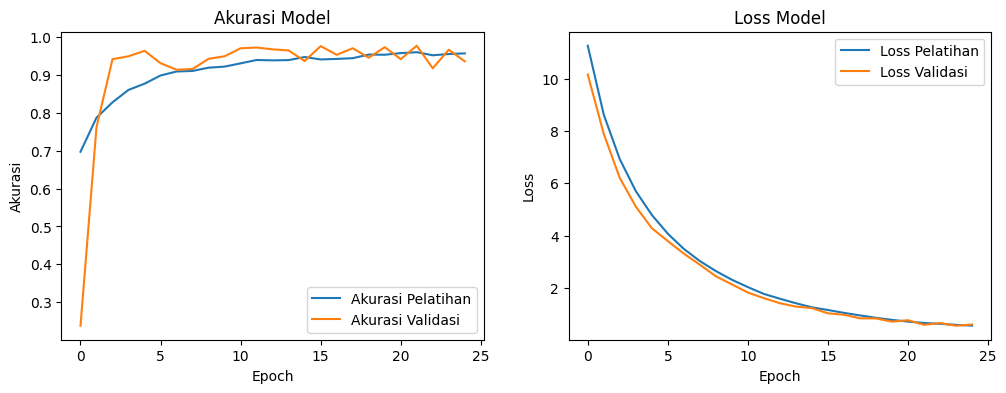

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

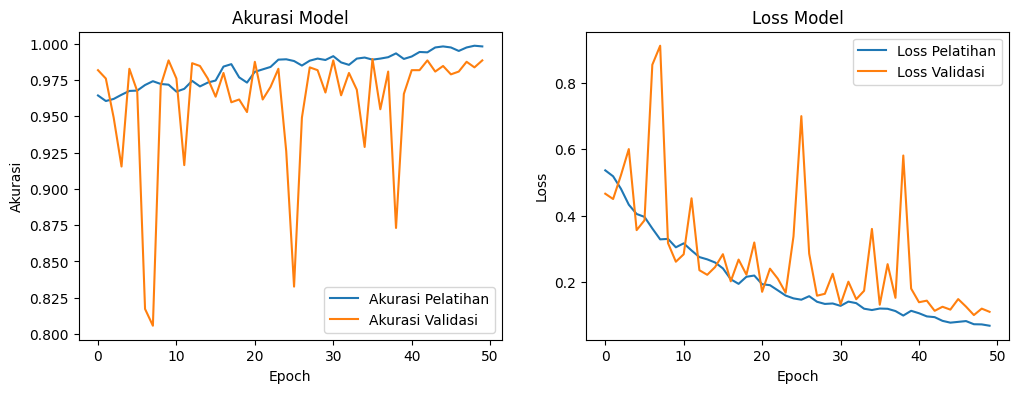

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

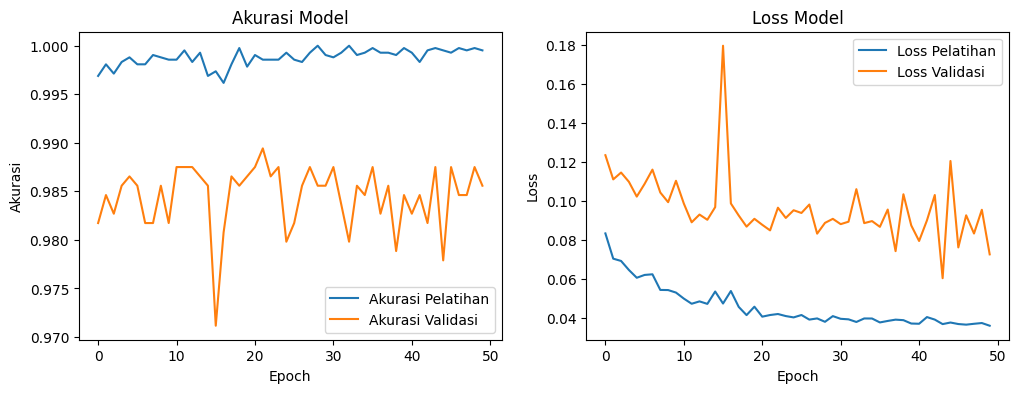

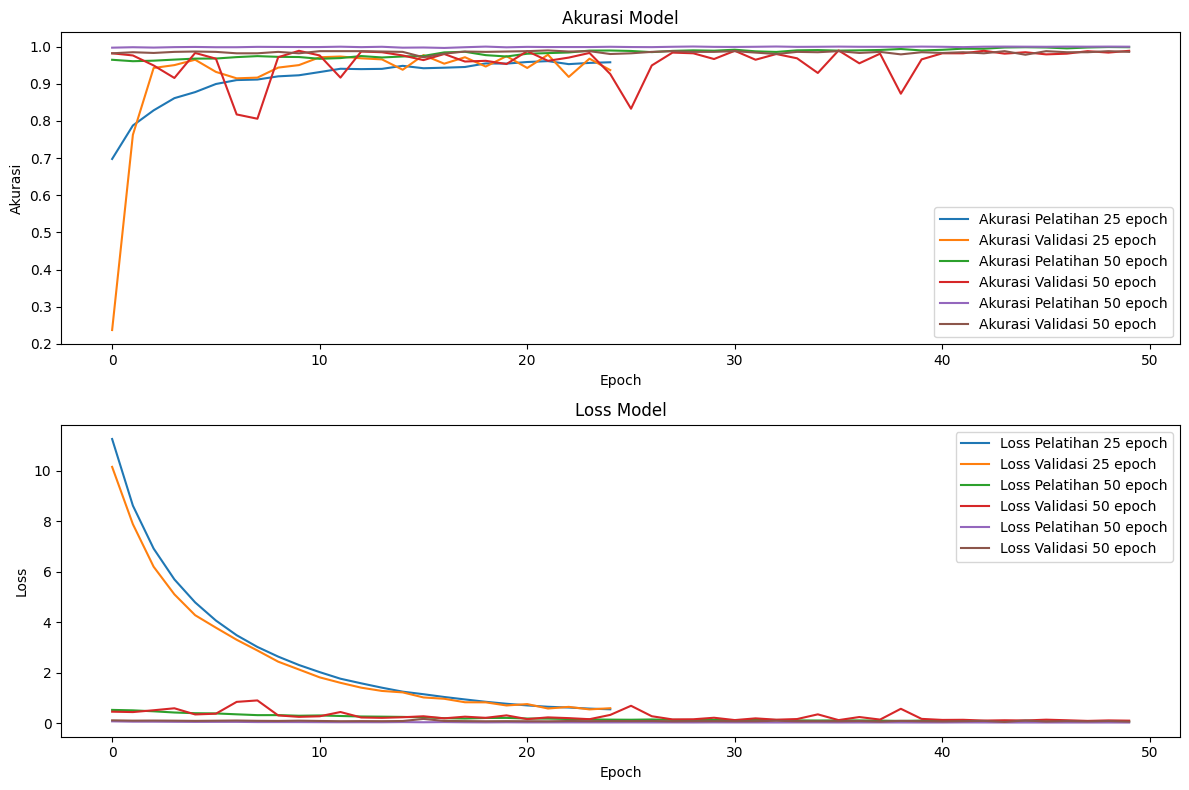

In [9]:
# Menghitung bias awal
initial_bias = np.log([COUNT_PNEUMONIA_TRAIN / COUNT_NORMAL_TRAIN])
print(f'Bias Awal: {initial_bias[0]:.4f}')

# Menghitung bobot kelas
weight_for_0 = (1 / COUNT_NORMAL_TRAIN) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA_TRAIN) * (TRAIN_IMG_COUNT) / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

# Membangun dan mengompilasi model
with strategy.scope():
    model = build_model()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

# Menampilkan ringkasan model
model.summary()

# Mendefinisikan callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Pelatihan awal dengan 25 epoch
history_initial = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    epochs=25,
    class_weight=class_weight,
    verbose=0,
    callbacks=[TqdmCallback(), early_stopping, checkpoint, reduce_lr]
)

plot_metrics(history_initial)

# Fine-tuning pertama dengan 50 epoch
history_finetune_1 = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    epochs=50,
    class_weight=class_weight,
    verbose=0,
    callbacks=[TqdmCallback(), early_stopping, checkpoint, reduce_lr]
)

plot_metrics(history_finetune_1)

# Fine-tuning kedua dengan 50 epoch
history_finetune_2 = model.fit(
    train_ds,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    validation_data=val_ds,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    epochs=50,
    class_weight=class_weight,
    verbose=0,
    callbacks=[TqdmCallback(), early_stopping, checkpoint, reduce_lr]
)

plot_metrics(history_finetune_2)

# Plot metrik gabungan
plot_combined_metrics(
    [history_initial, history_finetune_1, history_finetune_2],
    ['25 epoch', '50 epoch', '50 epoch']
)

# Evaluasi Model Sebelum SVM
Mengevaluasi performa model CNN sebelum dikombinasikan dengan SVM.

# Ekstraksi Fitur untuk SVM
Mengekstraksi fitur dari layer terakhir model CNN untuk digunakan dengan SVM.

In [10]:
# Ekstraksi fitur dari model yang telah dilatih
train_features, train_labels = extract_features_with_progress(model, train_ds, TRAIN_IMG_COUNT // BATCH_SIZE)
val_features, val_labels = extract_features_with_progress(model, val_ds, VAL_IMG_COUNT // BATCH_SIZE)

# Standarisasi fitur
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

Ekstraksi fitur: 100%|██████████| 65/65 [00:18<00:00,  3.49it/s]


# Pelatihan dan Evaluasi SVM
Melatih model SVM dengan fitur yang diekstraksi dan mengevaluasi performanya.

Kernel: linear, C: 0.1
Akurasi SVM: 98.37%
Presisi SVM: 98.87%
Recall SVM: 98.99%
F1-Score: 98.93%
--------------------------------------------------


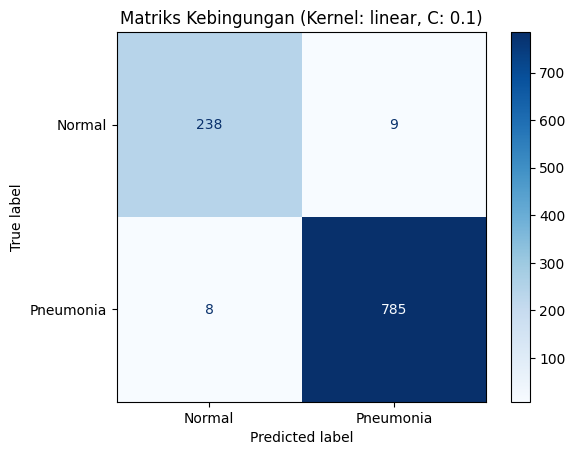

Kernel: linear, C: 1
Akurasi SVM: 98.37%
Presisi SVM: 98.87%
Recall SVM: 98.99%
F1-Score: 98.93%
--------------------------------------------------


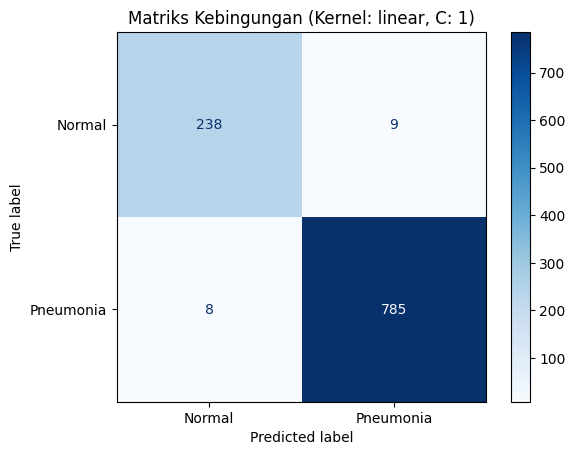

Kernel: linear, C: 10
Akurasi SVM: 98.37%
Presisi SVM: 98.87%
Recall SVM: 98.99%
F1-Score: 98.93%
--------------------------------------------------


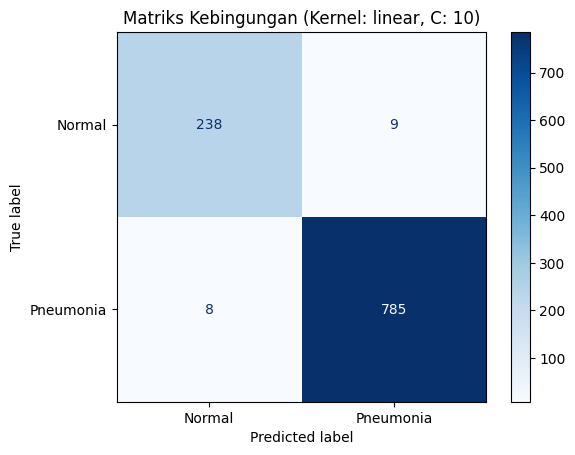

Kernel: rbf, C: 0.1
Akurasi SVM: 98.37%
Presisi SVM: 98.87%
Recall SVM: 98.99%
F1-Score: 98.93%
--------------------------------------------------


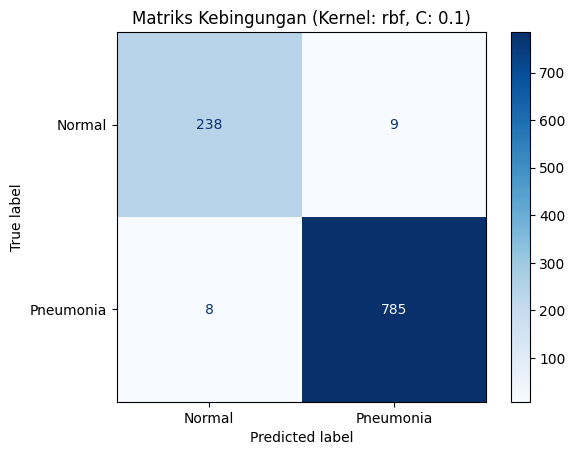

Kernel: rbf, C: 1
Akurasi SVM: 98.37%
Presisi SVM: 98.87%
Recall SVM: 98.99%
F1-Score: 98.93%
--------------------------------------------------


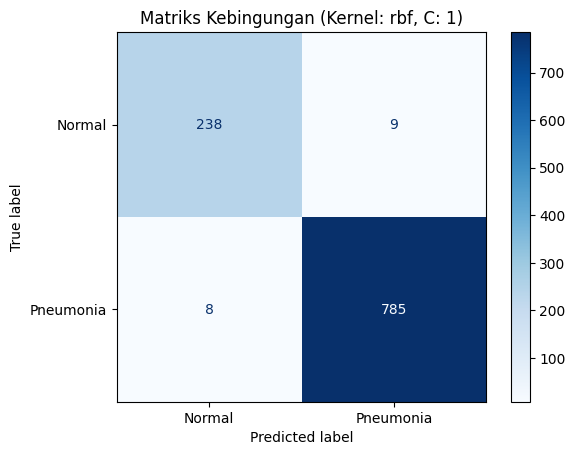

Kernel: rbf, C: 10
Akurasi SVM: 98.37%
Presisi SVM: 98.87%
Recall SVM: 98.99%
F1-Score: 98.93%
--------------------------------------------------


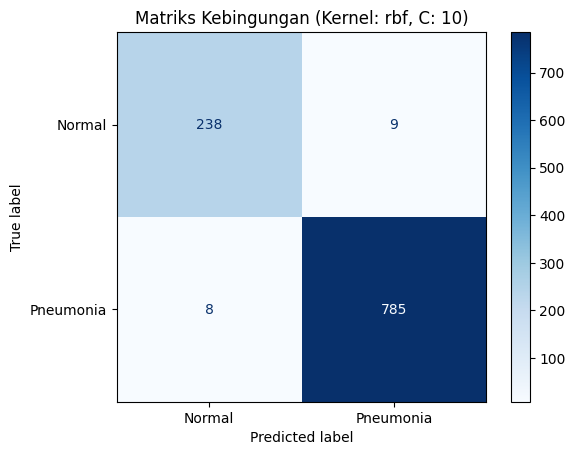

Kernel: poly, C: 0.1
Akurasi SVM: 98.56%
Presisi SVM: 98.75%
Recall SVM: 99.37%
F1-Score: 99.06%
--------------------------------------------------


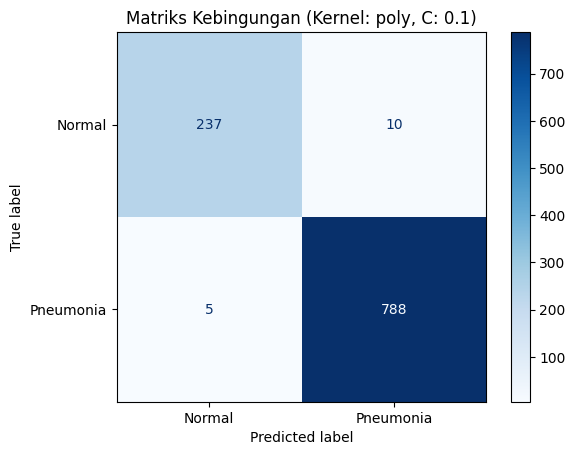

Kernel: poly, C: 1
Akurasi SVM: 98.56%
Presisi SVM: 98.75%
Recall SVM: 99.37%
F1-Score: 99.06%
--------------------------------------------------


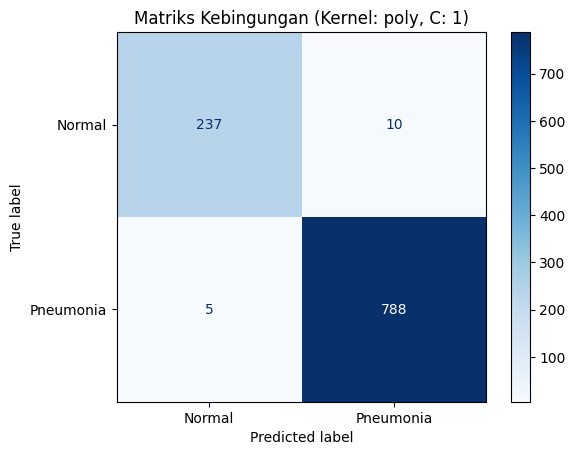

Kernel: poly, C: 10
Akurasi SVM: 98.56%
Presisi SVM: 98.75%
Recall SVM: 99.37%
F1-Score: 99.06%
--------------------------------------------------


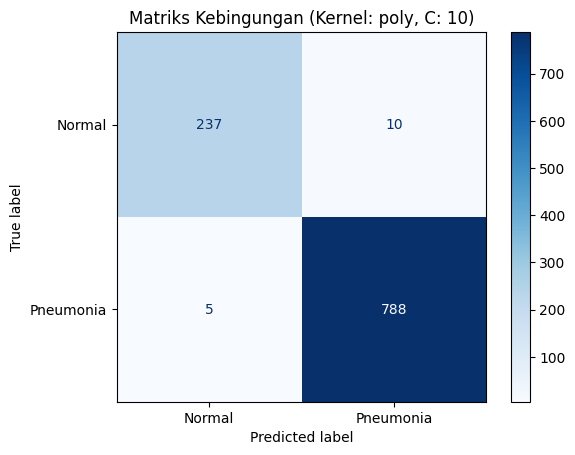

Ringkasan Hasil Evaluasi Model SVM:
+--------+------+----------+----------+----------+----------+
| Kernel |  C   | Akurasi  | Presisi  |  Recall  | F1-Score |
+--------+------+----------+----------+----------+----------+
| linear | 0.1  | 98.3654% | 98.8665% | 98.9912% | 98.9288% |
| linear | 1.0  | 98.3654% | 98.8665% | 98.9912% | 98.9288% |
| linear | 10.0 | 98.3654% | 98.8665% | 98.9912% | 98.9288% |
|  rbf   | 0.1  | 98.3654% | 98.8665% | 98.9912% | 98.9288% |
|  rbf   | 1.0  | 98.3654% | 98.8665% | 98.9912% | 98.9288% |
|  rbf   | 10.0 | 98.3654% | 98.8665% | 98.9912% | 98.9288% |
|  poly  | 0.1  | 98.5577% | 98.7469% | 99.3695% | 99.0572% |
|  poly  | 1.0  | 98.5577% | 98.7469% | 99.3695% | 99.0572% |
|  poly  | 10.0 | 98.5577% | 98.7469% | 99.3695% | 99.0572% |
+--------+------+----------+----------+----------+----------+

Kernel dan Parameter Regularisasi Terbaik Berdasarkan Akurasi:
+--------+-----+----------+----------+----------+----------+
| Kernel |  C  | Akurasi  | Presi

In [11]:
# Evaluasi SVM dengan kernel dan nilai C yang berbeda
kernels = ['linear', 'rbf', 'poly']
C_values = [0.1, 1, 10]
results = []

for kernel in kernels:
    for C in C_values:
        svm = SVC(kernel=kernel, C=C)
        svm.fit(train_features, train_labels)
        val_predictions = svm.predict(val_features)

        results.append({
            'Kernel': kernel,
            'C': C,
            'Akurasi': accuracy_score(val_labels, val_predictions) * 100,
            'Presisi': precision_score(val_labels, val_predictions) * 100,
            'Recall': recall_score(val_labels, val_predictions) * 100,
            'F1-Score': f1_score(val_labels, val_predictions) * 100
        })

        display_evaluation(kernel, C, val_labels, val_predictions)

# Menampilkan Hasil Evaluasi SVM

# Membuat DataFrame untuk hasil
results_df = pd.DataFrame(results)
results_df['Akurasi'] = results_df['Akurasi'].map(lambda x: f"{x:.4f}%")
results_df['Presisi'] = results_df['Presisi'].map(lambda x: f"{x:.4f}%")
results_df['Recall'] = results_df['Recall'].map(lambda x: f"{x:.4f}%")
results_df['F1-Score'] = results_df['F1-Score'].map(lambda x: f"{x:.4f}%")

print("Ringkasan Hasil Evaluasi Model SVM:")
print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

# Menemukan dan menampilkan hasil terbaik berdasarkan akurasi
best_result = results_df.loc[results_df['Akurasi'].idxmax()].to_frame().T
print("\nKernel dan Parameter Regularisasi Terbaik Berdasarkan Akurasi:")
print(tabulate(best_result, headers='keys', tablefmt='pretty', showindex=False))

# Menampilkan Hasil Evaluasi SVM
Menampilkan hasil evaluasi model SVM dan membandingkannya dengan model CNN.

Ringkasan Hasil Evaluasi Model SVM:
+--------+------+----------+----------+----------+----------+
| Kernel |  C   | Akurasi  | Presisi  |  Recall  | F1-Score |
+--------+------+----------+----------+----------+----------+
| linear | 0.1  | 98.3654% | 98.8665% | 98.9912% | 98.9288% |
| linear | 1.0  | 98.3654% | 98.8665% | 98.9912% | 98.9288% |
| linear | 10.0 | 98.3654% | 98.8665% | 98.9912% | 98.9288% |
|  rbf   | 0.1  | 98.3654% | 98.8665% | 98.9912% | 98.9288% |
|  rbf   | 1.0  | 98.3654% | 98.8665% | 98.9912% | 98.9288% |
|  rbf   | 10.0 | 98.3654% | 98.8665% | 98.9912% | 98.9288% |
|  poly  | 0.1  | 98.5577% | 98.7469% | 99.3695% | 99.0572% |
|  poly  | 1.0  | 98.5577% | 98.7469% | 99.3695% | 99.0572% |
|  poly  | 10.0 | 98.5577% | 98.7469% | 99.3695% | 99.0572% |
+--------+------+----------+----------+----------+----------+

Kernel dan Parameter Regularisasi Terbaik Berdasarkan Akurasi:
+--------+-----+----------+----------+----------+----------+
| Kernel |  C  | Akurasi  | Presi

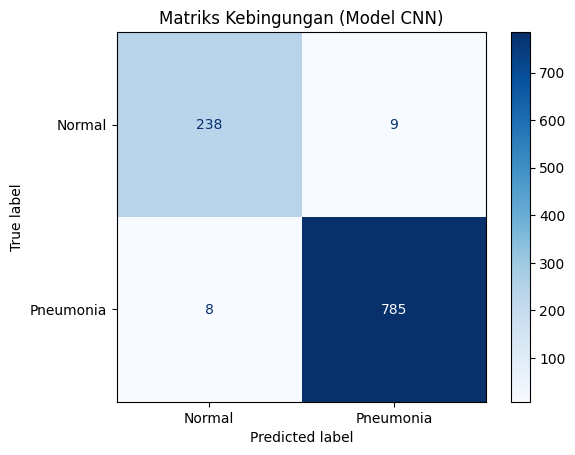


Ringkasan Hasil Akhir:
+-----------+----------+----------+----------+----------+
|   Model   | Akurasi  | Presisi  |  Recall  | F1-Score |
+-----------+----------+----------+----------+----------+
|    CNN    |  98.37%  |  98.87%  |  98.99%  |  98.93%  |
| CNN + SVM | 98.5577% | 98.7469% | 99.3695% | 99.0572% |
+-----------+----------+----------+----------+----------+


In [12]:
# Menampilkan Hasil Evaluasi SVM

# Membuat DataFrame untuk hasil
results_df = pd.DataFrame(results)
results_df['Akurasi'] = results_df['Akurasi'].map(lambda x: f"{x:.4f}%")
results_df['Presisi'] = results_df['Presisi'].map(lambda x: f"{x:.4f}%")
results_df['Recall'] = results_df['Recall'].map(lambda x: f"{x:.4f}%")
results_df['F1-Score'] = results_df['F1-Score'].map(lambda x: f"{x:.4f}%")

print("Ringkasan Hasil Evaluasi Model SVM:")
print(tabulate(results_df, headers='keys', tablefmt='pretty', showindex=False))

# Menemukan dan menampilkan hasil terbaik berdasarkan akurasi
best_result = results_df.loc[results_df['Akurasi'].idxmax()].to_frame().T
print("\nKernel dan Parameter Regularisasi Terbaik Berdasarkan Akurasi:")
print(tabulate(best_result, headers='keys', tablefmt='pretty', showindex=False))

# Memodifikasi fungsi evaluate_model untuk mengembalikan metrik evaluasi
def evaluate_model(model, val_ds, steps):
    val_labels = []
    val_predictions = []
    for imgs, labels in val_ds.take(steps):
        predictions = model.predict(imgs)
        val_predictions.extend(predictions)
        val_labels.extend(labels.numpy())
    val_predictions = np.array(val_predictions).round().astype(int)
    val_labels = np.array(val_labels)

    accuracy = accuracy_score(val_labels, val_predictions)
    precision = precision_score(val_labels, val_predictions)
    recall = recall_score(val_labels, val_predictions)
    f1 = f1_score(val_labels, val_predictions)

    print(f'Evaluasi Model CNN:')
    print(f'Akurasi: {accuracy * 100:.2f}%')
    print(f'Presisi: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1-Score: {f1 * 100:.2f}%')

    cm = confusion_matrix(val_labels, val_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Matriks Kebingungan (Model CNN)')
    plt.show()

    return accuracy, precision, recall, f1

# Mengevaluasi ulang model CNN dan menyimpan metriknya
steps = VAL_IMG_COUNT // BATCH_SIZE
cnn_accuracy, cnn_precision, cnn_recall, cnn_f1 = evaluate_model(model, val_ds, steps)

# Mengambil hasil SVM terbaik
best_result = results_df.loc[results_df['Akurasi'].idxmax()]
svm_accuracy = float(best_result['Akurasi'].strip('%')) / 100
svm_precision = float(best_result['Presisi'].strip('%')) / 100
svm_recall = float(best_result['Recall'].strip('%')) / 100
svm_f1 = float(best_result['F1-Score'].strip('%')) / 100

# Membuat DataFrame untuk hasil CNN
cnn_results_df = pd.DataFrame({
    'Model': ['CNN'],
    'Akurasi': [f"{cnn_accuracy * 100:.2f}%"],
    'Presisi': [f"{cnn_precision * 100:.2f}%"],
    'Recall': [f"{cnn_recall * 100:.2f}%"],
    'F1-Score': [f"{cnn_f1 * 100:.2f}%"]
})

# Membuat DataFrame untuk hasil SVM terbaik
svm_results_df = pd.DataFrame({
    'Model': ['CNN + SVM'],
    'Akurasi': [best_result['Akurasi']],
    'Presisi': [best_result['Presisi']],
    'Recall': [best_result['Recall']],
    'F1-Score': [best_result['F1-Score']]
})

# Menggabungkan hasil
final_results_df = pd.concat([cnn_results_df, svm_results_df], ignore_index=True)

print("\nRingkasan Hasil Akhir:")
print(tabulate(final_results_df, headers='keys', tablefmt='pretty', showindex=False))